## Load and Normalize Data

In [271]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
import xgboost

import warnings
warnings.filterwarnings("ignore")

In [272]:
# Data file paths
train_raw_path, test_raw_path = r'../data/train_raw.csv', r'../data/test_raw.csv'
train_path, test_path = r'../data/train.csv', r'../data/test.csv'

# Open csv files
train_raw_data = np.loadtxt(train_raw_path, dtype='str', delimiter=',', unpack=True).T
test_raw_data = np.loadtxt(test_raw_path, dtype='str', delimiter=',', unpack=True).T

N_train, N_test = train_raw_data.shape[0] - 1, test_raw_data.shape[0] - 1

In [273]:
normalizations = \
{
    0:  {'Female': 0, 'Male': 1},
    2:  {'No': 0, 'Yes': 1},
    3:  {'No': 0, 'Yes': 1},
    5:  {'No': 0, 'Yes': 1},
    6:  {'No phone service': 0, 'No': 1, 'Yes': 2},
    7:  {'No': 0, 'DSL': 1, 'Fiber optic': 2},
    8:  {'No internet service': 0, 'No': 1, 'Yes': 2},
    9:  {'No internet service': 0, 'No': 1, 'Yes': 2},
    10: {'No internet service': 0, 'No': 1, 'Yes': 2},
    11: {'No internet service': 0, 'No': 1, 'Yes': 2},
    12: {'No internet service': 0, 'No': 1, 'Yes': 2},
    13: {'No internet service': 0, 'No': 1, 'Yes': 2},
    14: {'Month-to-month': 0, 'One year': 1, 'Two year': 2},
    15: {'No': 0, 'Yes': 1},
    16: {'Mailed check': 0, 'Bank transfer (automatic)': 1, 'Electronic check': 2, 'Credit card (automatic)': 3},
}

## Including All Features

In [274]:
num_features = train_raw_data.shape[1] - 2

# Initialize arrays for train and test data
train_X, train_Y = np.zeros((N_train, train_raw_data.shape[1] - 2)), np.zeros((N_train, 1))
test_X, test_Y = np.zeros((N_test, test_raw_data.shape[1] - 1)), np.zeros((N_test, 1))

for i in range(N_train):
    train_raw_x, train_raw_y = train_raw_data[i+1, 1:-1], train_raw_data[i+1, -1]
    
    train_x = np.zeros((num_features))
    for j in range(num_features):
        if j in normalizations.keys():
            train_x[j] = normalizations[j][train_raw_x[j]]
        else:
            if j == 18 and not train_raw_x[j]:              # If 'Total Charges' missing, calculate from 'tenure' and 'Monthly Charges'
                train_x[j] = train_x[4] * train_x[17]  
            else:
                train_x[j] = eval(train_raw_x[j])
    
    train_y = 1 if train_raw_y == 'Yes' else 0
    
    
    train_X[i], train_Y[i] = train_x, train_y

for i in range(N_test):
    test_raw_x = test_raw_data[i+1, 1:]
    
    test_x = np.zeros((num_features))
    for j in range(num_features):
        if j in normalizations.keys():
            test_x[j] = normalizations[j][test_raw_x[j]]
        else:
            if j == 18 and not test_raw_x[j]:              # If 'Total Charges' missing, calculate from 'tenure' and 'Monthly Charges'
                test_x[j] = test_x[4] * test_x[17]  
            else:
                test_x[j] = eval(test_raw_x[j])
            
    test_X[i] = test_x

def cross_validation_lr(X, Y, n_splits, C=1):
    kf = KFold(n_splits=n_splits)
    
    E_trains, E_vals = [], []
    for train_index, val_index in kf.split(X):
        X_train, Y_train = X[train_index], Y[train_index]
        X_val, Y_val = X[val_index], Y[val_index]
        
        model = xgboost.XGBRFClassifier(objective='binary:logistic')
        model.fit(X_train, Y_train)
        
        E_train = model.score(X_train, Y_train)
        E_val = model.score(X_val, Y_val)
        
        E_trains.append(E_train)
        E_vals.append(E_val)
    
    avg_E_train, avg_E_val = np.mean(E_trains), np.mean(E_vals)
    
    return avg_E_train, avg_E_val

E_train, E_val = cross_validation_lr(train_X, train_Y, n_splits=5, C=400)
default_train_acc = E_train
default_val_acc = E_val
print(f"All Features:   \t ({round(E_train, 4)}, {round(E_val, 4)})")

All Features:   	 (0.821, 0.7958)


## Remove Features

In [282]:
num_features = train_raw_data.shape[1] - 2
train_X, train_Y = np.zeros((N_train, train_raw_data.shape[1] - 3)), np.zeros((N_train, 1))
test_X, test_Y = np.zeros((N_test, test_raw_data.shape[1] - 2)), np.zeros((N_test, 1))

validation_acc_wo_features= []
training_acc_wo_features = []

def cross_validation_lr(X, Y, n_splits, C=1):
    kf = KFold(n_splits=n_splits)
    
    E_trains, E_vals = [], []
    for train_index, val_index in kf.split(X):
        X_train, Y_train = X[train_index], Y[train_index]
        X_val, Y_val = X[val_index], Y[val_index]
        
        model = xgboost.XGBRFClassifier(objective='binary:logistic')
        model.fit(X_train, Y_train)
        
        E_train = model.score(X_train, Y_train)
        E_val = model.score(X_val, Y_val)
        
        E_trains.append(E_train)
        E_vals.append(E_val)
    
    avg_E_train, avg_E_val = np.mean(E_trains), np.mean(E_vals)
    
    return avg_E_train, avg_E_val

for k in range(num_features):
    curr_train_x = np.delete(train_raw_data, k + 1, axis=1)
    curr_test_x = np.delete(test_raw_data, k + 1, axis=1)

    for i in range(N_train):
        train_raw_x, train_raw_y = curr_train_x[i+1, 1:-1], curr_train_x[i+1, -1]
        
        train_x = np.zeros((num_features - 1))
        for j in range(num_features - 1):
            if j < k and j in normalizations.keys() :
                train_x[j] = normalizations[j][train_raw_x[j]]
            elif j >= k and j + 1 in normalizations.keys():
                train_x[j] = normalizations[j + 1][train_raw_x[j]]
            else:
                if (j == 17 and not train_raw_x[j] and k < 18) and k < 4:            # If 'Total Charges' missing, calculate from 'tenure' and 'Monthly Charges'
                    train_x[j] = train_x[3] * train_x[16]  
                elif (j == 17 and not train_raw_x[j] and k < 18) and k == 4:
                    train_x[j] = 0
                elif (j == 17 and not train_raw_x[j] and k < 18) and k > 4:            # If 'Total Charges' missing, calculate from 'tenure' and 'Monthly Charges'
                    train_x[j] = train_x[4] * train_x[16]  
                elif (j == 18 and not train_raw_x[j] and k > 18):            # If 'Total Charges' missing, calculate from 'tenure' and 'Monthly Charges'
                    train_x[j] = train_x[4] * train_x[17]  
                else:
                    train_x[j] = eval(train_raw_x[j])

        train_y = 1 if train_raw_y == 'Yes' else 0
        train_X[i], train_Y[i] = train_x, train_y
    
    # print(train_X[-5:,-5:])

    for i in range(N_test):    
        test_raw_x = curr_test_x[i+1, 1:]
        test_x = np.zeros((num_features - 1))
        for j in range(num_features - 1):
            if j < k and j in normalizations.keys() :
                test_x[j] = normalizations[j][test_raw_x[j]]
            elif j >= k and j + 1 in normalizations.keys():
                test_x[j] = normalizations[j + 1][test_raw_x[j]]
            else:
                if (j == 17 and not test_raw_x[j] and k < 18) and k < 4:            # If 'Total Charges' missing, calculate from 'tenure' and 'Monthly Charges'
                    test_x[j] = test_x[3] * test_x[16]  
                elif (j == 17 and not test_raw_x[j] and k < 18) and k > 4:            # If 'Total Charges' missing, calculate from 'tenure' and 'Monthly Charges'
                    test_x[j] = test_x[4] * test_x[16]  
                elif (j == 17 and not test_raw_x[j] and k < 18) and k == 4:
                    test_x[j] = 0  
                elif (j == 18 and not test_raw_x[j] and k > 18):            # If 'Total Charges' missing, calculate from 'tenure' and 'Monthly Charges'
                    test_x[j] = test_x[4] * test_x[17]  
                else:
                    test_x[j] = eval(test_raw_x[j])
    
    E_train, E_val = cross_validation_lr(train_X, train_Y, n_splits=5, C=400)
    validation_acc_wo_features.append(round(E_val, 4))
    training_acc_wo_features.append(round(E_train, 4))
    val_improvement = E_val - default_val_acc

    thresh = 0.00056

    if abs(val_improvement) > thresh:
        if val_improvement < -thresh:
            print(f"No {train_raw_data[0][k + 1][:7]}   \t ({round(E_train, 4)}, {round(E_val, 4)}) \tValidation Improvement: {round(val_improvement, 6)}\t\tKeep {train_raw_data[0][k + 1]}, index: {k}")
        else: 
            print(f"No {train_raw_data[0][k + 1][:7]}   \t ({round(E_train, 4)}, {round(E_val, 4)}) \tValidation Improvement: {round(val_improvement, 6)}\t\tRemove {train_raw_data[0][k + 1]}, index: {k}")
    else:
        print(f"No {train_raw_data[0][k + 1][:7]}   \t ({round(E_train, 4)}, {round(E_val, 4)}) \tValidation Improvement: {round(val_improvement, 6)}")

No gender   	 (0.822, 0.7954) 	Validation Improvement: -0.000374
No SeniorC   	 (0.8221, 0.7977) 	Validation Improvement: 0.001872		Remove SeniorCitizen, index: 1
No Partner   	 (0.8217, 0.7962) 	Validation Improvement: 0.000375
No Depende   	 (0.8224, 0.7958) 	Validation Improvement: 0.0
No tenure   	 (0.8214, 0.7969) 	Validation Improvement: 0.001123		Remove tenure, index: 4
No PhoneSe   	 (0.8213, 0.7975) 	Validation Improvement: 0.001685		Remove PhoneService, index: 5
No Multipl   	 (0.8202, 0.7967) 	Validation Improvement: 0.000936		Remove MultipleLines, index: 6
No Interne   	 (0.82, 0.7952) 	Validation Improvement: -0.00056
No OnlineS   	 (0.8207, 0.7943) 	Validation Improvement: -0.001497		Keep OnlineSecurity, index: 8
No OnlineB   	 (0.8222, 0.796) 	Validation Improvement: 0.000188
No DeviceP   	 (0.8219, 0.796) 	Validation Improvement: 0.000188
No TechSup   	 (0.8214, 0.7964) 	Validation Improvement: 0.000562		Remove TechSupport, index: 11
No Streami   	 (0.8214, 0.7939) 	Val

## Plot Effect of Specific Features

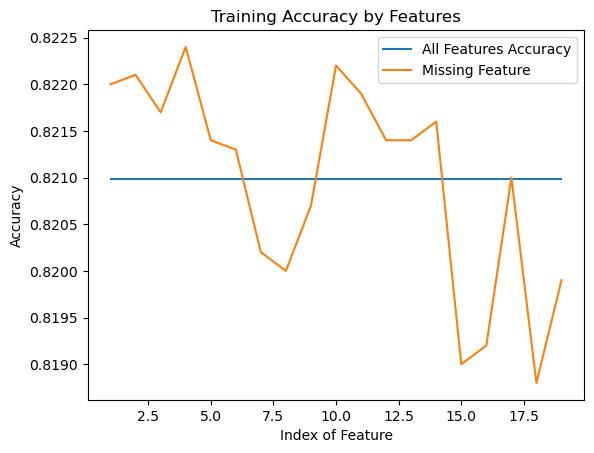

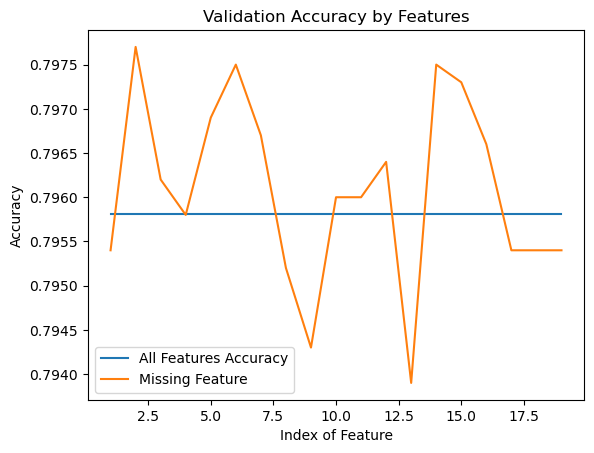

In [276]:
x_ax = np.arange(1,20)
train_val_all_features = []
val_val_all_features = []

for i in range(19):
    train_val_all_features.append(default_train_acc)
    val_val_all_features.append(default_val_acc)


plt.figure()
plt.plot(x_ax, train_val_all_features, label='All Features Accuracy')
plt.plot(x_ax, training_acc_wo_features, label='Missing Feature')
plt.xlabel('Index of Feature')
plt.ylabel('Accuracy')
# plt.ylim((0.8, 0.85))
plt.title('Training Accuracy by Features')
plt.legend(loc='best')
plt.show()

plt.figure()
plt.plot(x_ax, val_val_all_features, label='All Features Accuracy')
plt.plot(x_ax, validation_acc_wo_features, label='Missing Feature')
plt.xlabel('Index of Feature')
plt.ylabel('Accuracy')
# plt.ylim((0.78, 0.83))
plt.title('Validation Accuracy by Features')
plt.legend(loc='best')
plt.show()
